In [1]:
import numpy as np
import astropy.units as u
import astropy.constants as ac 
from astroquery.splatalogue import Splatalogue
import astropy.units as u
from helpers import generate_smart_table, LTEmodel, get_CDMS_partition_function

ckms = ac.c.to(u.km/u.s).value


In [2]:
# lines of interest
specie = [
    # "NH3",
    "NH2D",
    "NHD2",
    "ND3",
    # "CH3OH",
    # "CH3(18)OH",
    # "(13)CH3OH",
    # "CH2DOH"
    #"CH3OCHO"
]  # spaces are needed to specify the particular ones
pf_name = {"NH3": "NH3-wHFS",
           "NH2D": "NH2D",
           "NHD2": "NHD2",
           "ND3": "ND3",
           "CH3OH": "CH3OH",
           "CH3(18)OH": "CH3O-18-H",
           "(13)CH3OH": "C-13-H3OH",
           "CH2DOH": "CH2DOH"}

# frequency range of interest 
nu_range = (290 * u.GHz, 330 * u.GHz)

line_query = {}
specie_id = {}
pf = {}
for s in specie:
    if s == "NH3":
        chemical_name = " NH3 v=0 "
        #pf_name = "NH3-wHFS"
    else:
        chemical_name = " {:s} ".format(s)
        #pf_name = s
    q = Splatalogue.query_lines(
        *nu_range,
        chemical_name=chemical_name,
        line_lists=["CDMS", "JPL"],
        show_upper_degeneracy=True,
        # line_strengths=["ls4"],
        # energy_type="eu_k",
    )
    # id = Splatalogue.get_species_ids(chemical_name)
    # specie_id[s] = id
    line_query[s] = generate_smart_table(q, hfs=False)
    pf[s] = get_CDMS_partition_function(pf_name[s])
line_query

[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 3793.14984974 2466.03933723 1346.79036263
  481.61499484  174.58221529   64.90826491   25.46243891           nan
           nan]
[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 3970.08678112 2580.47704444 1407.99139304
  502.68971537  181.55156628   67.06562867   25.95971977   12.52275835
    9.05107159]
[1000.     500.     300.     225.     150.      75.      37.5     18.75
    9.375    5.       2.725] [          nan           nan 5313.73632119 3455.41329578 1886.68762122
  673.13163273  242.54928571   89.43345319   35.28580258           nan
           nan]


{'NH2D': <Table length=16>
 Species         QNs           nu0 [GHz]  ... Smu2 [D^2]   g_u    E_u [K]  
   str4         str27           float64   ...  float64   float64  float64  
 ------- -------------------- ----------- ... ---------- ------- ----------
    NH2D    8(3,5)0s-9(0,9)0a 290.2263825 ...    0.01582   153.0  658.49364
    NH2D    7(1,7)0s-6(3,4)0s 292.6279798 ...    0.00257   135.0  406.68295
    NH2D  13(9,5)0a-14(6,9)0s 295.2265958 ...    0.01943    81.0 1933.94953
    NH2D    9(4,6)0a-9(3,6)0s   296.42466 ...   83.03019   171.0  825.59792
    NH2D    6(1,5)0s-5(4,1)0a 298.4394676 ...    0.16723   117.0  351.40165
    NH2D    9(5,4)0s-8(7,1)0s 301.8715093 ...    0.00179   171.0  880.08968
    NH2D    9(5,4)0a-8(7,1)0a 302.2247493 ...    0.00045    57.0  880.49035
    NH2D    3(1,2)0a-3(1,3)0a 305.5261657 ...    0.08397    21.0  109.16449
    NH2D    2(2,1)0a-2(1,1)0s   305.72367 ...   15.91768    45.0   72.23733
    NH2D    3(1,2)0s-3(1,3)0s  306.019188 ...    0.32627    6

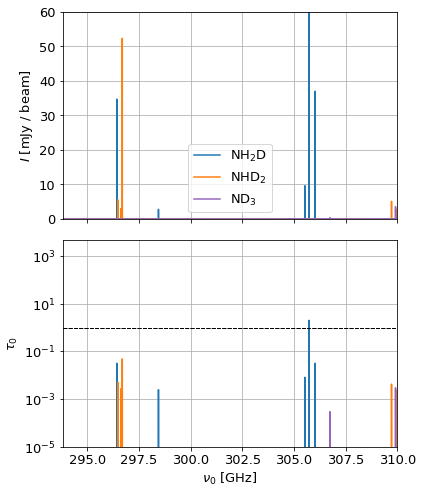

In [19]:
# assume IRAS 16293 abundance
# specie = ["NH2D", "NHD2"]

N = {'NH3': 5.3e20 * 0.05,
     'NH2D': 5.3e20 * 0.05 * 4e-3,
     'NHD2': 5.3e20 * 0.05 * 4e-3 * 1.8e-2,
     'ND3': 5.3e20 * 0.05 * 4e-3 * 1.8e-2 * 1.7e-2,
     #'15NH3': 5.3e20 * 0.05 / 300.
    }

# N = {'NH3': 9.5e19,
#      'NH2D': 3.8e17,
#      'NHD2': 6.9e15,
#      'ND3': 5.3e20 * 0.05 * 4e-3 * 1.8e-2 * 1.8e-1,
#      "CH3OH": 1.3e19
#      #'15NH3': 5.3e20 * 0.05 / 300.
#     }

# N = {"NH2D": 4.9e17,
#      "NHD2": 8.8e15,
#      "ND3": 1.5e14}

Tex = 130
# Tex = 200
# Tex = 160
DeltaV = 2.0

beam = 0.5 * u.arcsec # in arcsec
source_size = 0.5 * u.arcsec # in arcsec
f = source_size ** 2 / (source_size ** 2 + beam ** 2)
beam_area = np.pi / (4 * np.log(2)) * beam ** 2

# axis
nu_min = nu_range[0].value*1e9
nu_max = nu_range[1].value*1e9
dnu = nu_min / ckms * DeltaV / 5.0
nu = np.arange(nu_min, nu_max, dnu)

I_all = {}
tau_all = {}
for s in specie:
    I_all_s = 0
    tau_all_s = 0
    for trans in line_query[s]:
        I, t = LTEmodel(
            nu=nu,
            nu0=trans["nu0 [GHz]"] * 1e9,
            g_u=trans["g_u"],
            E_u=trans["E_u [K]"],
            A_ul=10 ** trans["logA [s^-1]"],
            N=N[s],
            Tex=Tex,
            DeltaV=DeltaV,
            f=f,
            Q=pf[s](Tex),
        )

        

        I_all_s += I.to(u.Jy/u.sr)
        tau_all_s += t
    I_all[s] = I_all_s.to(u.mJy/u.beam, equivalencies=u.beam_angular_area(beam_area))
    tau_all[s] = tau_all_s
I_all
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

xlim = (293.8, 310)
# xlim = (309.8, 310)
#xlim = (318, 322)
color = {'NH2D': 'tab:blue',
         'NHD2': 'tab:orange',
         'ND3': 'tab:purple',
         "CH3OH": "tab:green"
         #"ND3": "tab:green",
         }

label = {'NH3': 'NH$_3$',
         'NH2D': 'NH$_2$D',
         'NHD2': 'NHD$_2$',
         'ND3': 'ND$_3$',
         "CH3OH": "CH$_3$OH"}

for s in specie:
    # intenisty
    ax[0].plot(nu*1e-9, I_all[s], color=color[s], label=label[s])
    ax[0].set(xlim=xlim, ylim=(0, 60), ylabel=r'$I$ [mJy / beam]')
    #ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    #ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax[0].legend()
    
    # tau
    ax[1].plot(nu*1e-9, tau_all[s], color=color[s])
    ax[1].axhline(y=1.0, color='black', ls='--', lw=1.0)
    ax[1].set(xlim=xlim, xlabel=r'$\nu_0$ [GHz]', ylabel=r'$\tau_0$', yscale='log', ylim=(1e-5, 5e3))

ax[0].grid()
ax[1].grid()
plt.subplots_adjust(hspace=0.1)

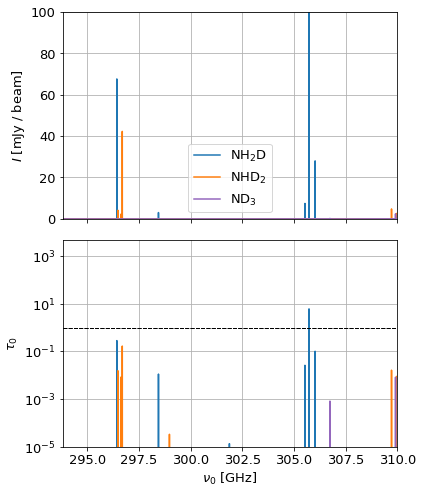

In [14]:
# IRAS 4A2

N = {"NH2D": 4.9e17,
     "NHD2": 4.9e17 * 1.8e-2,
     "ND3": 4.9e17 * 1.8e-2 * 1.7e-2}

# N = {"NH2D": 1.7e19 * 0.05 * 4e-3,
#      "NHD2": 1.7e19 * 0.05 * 4e-3 * 1.8e-2,
#      "ND3": 1.7e19 * 0.05 * 4e-3 * 1.8e-2 * 1.7e-2
#      }

tau300 = 0.6

# Tex = 130
# Tex = 200
Tex = 160
DeltaV = 2

beam = 0.3 * u.arcsec # in arcsec
source_size = 0.3 * u.arcsec # in arcsec
f = source_size ** 2 / (source_size ** 2 + beam ** 2)
beam_area = np.pi / (4 * np.log(2)) * beam ** 2

# axis
nu_min = nu_range[0].value*1e9
nu_max = nu_range[1].value*1e9
dnu = nu_min / ckms * DeltaV / 5.0
nu = np.arange(nu_min, nu_max, dnu)

I_all = {}
tau_all = {}
for s in specie:
    I_all_s = 0
    tau_all_s = 0
    for trans in line_query[s]:
        I, t = LTEmodel(
            nu=nu,
            nu0=trans["nu0 [GHz]"] * 1e9,
            g_u=trans["g_u"],
            E_u=trans["E_u [K]"],
            A_ul=10 ** trans["logA [s^-1]"],
            N=N[s],
            Tex=Tex,
            DeltaV=DeltaV,
            f=f,
            Q=pf[s](Tex),
        )

        

        I_all_s += I.to(u.Jy/u.sr)
        tau_all_s += t
    I_all[s] = I_all_s.to(u.mJy/u.beam, equivalencies=u.beam_angular_area(beam_area)) * np.exp(-tau300)
    tau_all[s] = tau_all_s


import matplotlib.pyplot as plt
from matplotlib import ticker

plt.rcParams['font.size'] = 13

fig, ax = plt.subplots(2, 1, figsize=(6, 8), sharex=True)

xlim = (293.8, 310)
# xlim = (309.8, 310)
#xlim = (318, 322)
# xlim = (296.5, 296.7)
color = {'NH2D': 'tab:blue',
         'NHD2': 'tab:orange',
         'ND3': 'tab:purple',
         "CH3OH": "tab:green"
         #"ND3": "tab:green",
         }

label = {'NH3': 'NH$_3$',
         'NH2D': 'NH$_2$D',
         'NHD2': 'NHD$_2$',
         'ND3': 'ND$_3$',
         "CH3OH": "CH$_3$OH"}

for s in specie:
    # intenisty
    ax[0].plot(nu*1e-9, I_all[s], color=color[s], label=label[s])
    ax[0].set(xlim=xlim, ylim=(0, 100), ylabel=r'$I$ [mJy / beam]')
    #ax[0].xaxis.set_major_locator(ticker.MultipleLocator(1.0))
    #ax[0].yaxis.set_minor_locator(ticker.MultipleLocator(1.0))
    ax[0].legend()
    
    # tau
    ax[1].plot(nu*1e-9, tau_all[s], color=color[s])
    ax[1].axhline(y=1.0, color='black', ls='--', lw=1.0)
    ax[1].set(xlim=xlim, xlabel=r'$\nu_0$ [GHz]', ylabel=r'$\tau_0$', yscale='log', ylim=(1e-5, 5e3))

ax[0].grid()
ax[1].grid()
plt.subplots_adjust(hspace=0.1)